In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math
from numpy.linalg import norm

In [43]:
class PreprocessData:
    '''
        Class to preprocess the data.
        
        Functions:
        1. remove_features - to remove the id feature or any other redundant feature.
        Input : a) dataset name
                b) list of features to be deleted
        
        2. split_date - to split the date feature into day, month and year
        Input : a) dataset name
        
        3. report_statistics - to report the statistics for each feature
        Input : a) dataset name
                b) list of numerical features (column names)
                c) list of categorical features (column names)
        
        4. normalise_features - to normalise the features to the range between 0 and 1. (applying min-max normalization)
                This function will normalise all the columns except the dummy column. Value of dummy is 1.
        Input : a) dataset name 
    '''
    def remove_features(self, dataset, feature_list):
        dataset = dataset.drop(feature_list, axis = 1)
        return dataset
    
    def split_date(self, dataset):
        datetime = pd.DatetimeIndex(dataset['date'])
        dataset['day'] = datetime.day
        dataset['month'] = datetime.month
        dataset['year'] = datetime.year
        return dataset
    
    def report_statistics(self, dataset, numerical_features, categorical_features):
        numerical_desc = train_df[numerical_features].describe()
        numerical_stats = pd.DataFrame()
#         categorical_stats = {}
        categorical_stats = []
    
        for feature in numerical_features:
            numerical_stats.loc['mean',feature] = numerical_desc[feature]['mean']
            numerical_stats.loc['sd',feature] = numerical_desc[feature]['std']
            numerical_stats.loc['range',feature] = "[%g,%g]" %(numerical_desc[feature]['min'],numerical_desc[feature]['max'])

        for category in categorical_features:
            categorical_stats.append(train_df[category].value_counts(normalize = True) *100)
        return numerical_stats, categorical_stats
    
    def normalise_features(self, dataset):
        # data normalised to a range between 0 and 1
        norm_dataset = (dataset.loc[:,dataset.columns!='dummy'] - dataset.loc[:,dataset.columns!='dummy'].min())/(dataset.loc[:,dataset.columns!='dummy'].max() - dataset.loc[:,dataset.columns!='dummy'].min())
        norm_dataset['dummy'] = dataset['dummy']
        return norm_dataset

In [38]:
class TrainModel:
    '''
        Class to train the model.
        
        Functions:
        1. initialize_values: Separate X(Input), Y(actual output), and initialize W to zeros.
        Input : a) dataset name
            
        2. calculate_cost: To calculate sum of square (cost).
        Input : a) loss
                b) regularize_lambda
                c) Weights
        
        3. train_gradient_descent: To train the model using gradient descent.
        Input : a) dataset name
                b) regularization lambda
                c) learning rate
                d) threshold
                e) maximum no of iterations
        
        4. plot_results: Plot the results for the loss.
        Input : a) learning_rate
                b) cost list
        
    '''
    def initialize_values(self, data):
        X = data[:,:-1]
        Y = data[:,-1].reshape(data.shape[0],1)
        W = np.zeros(data[:,:-1].shape[1],).reshape(data[:,:-1].shape[1],1)
        return X, Y, W
    
    def calculate_cost(self, loss, regularize_lambda, W):
        return (np.sum(np.square(loss)) +  regularize_lambda * np.sum(np.square(W)))
        
    def train_gradient_descent(self, data, regularize_lambda, learning_rate, epsilon, max_iter):
        X, Y, W = self.initialize_values(data)
        W_interm = W
        sses = []
        itern = 0
        l1norm = math.inf

        while itern < max_iter:
            loss = np.subtract(np.dot(X, W), Y)
            delta_error = np.dot(X.transpose(), loss) 
            delta_error[1:] += np.abs(W[1:])*regularize_lambda
            if np.isinf(delta_error).any() or np.isnan(delta_error).any():
                break
            
            W = np.subtract(W, (learning_rate * delta_error))
            
            sse = self.calculate_cost(loss, regularize_lambda, W)
            if np.isinf(sse) or np.isnan(sse):
                break
            
            l1norm = norm(delta_error)
            if l1norm <= epsilon:
                break
            
            itern += 1
            sses.append(sse)
            W_interm = W
        return W_interm, sses
    
    def train_gradient_descent_with_val(self, train_data, val_data, regularize_lambda, learning_rate, epsilon, max_iter):
        X, Y, W = self.initialize_values(train_data)
        X_val = val_data[:,:-1]
        Y_val = val_data[:,-1].reshape(val_data.shape[0],1)
        W_interm = W
        sses = []
        sses_val = []
        itern = 0
        l1norm = math.inf
        l1norm_prev = math.inf
        
        while itern < max_iter:
            loss = np.subtract(np.dot(X, W), Y)
            loss_val = np.subtract(np.dot(X_val, W), Y_val)
            
            delta_error = np.dot(X.transpose(), loss) 
            delta_error[1:] += np.abs(W[1:])*regularize_lambda

            if np.isinf(delta_error).any() or np.isnan(delta_error).any():
                break

            W = np.subtract(W, learning_rate * delta_error)
        
            # calculate SSE on training and validation dataset.
            sse = self.calculate_cost(loss, regularize_lambda, W)
            sse_val = self.calculate_cost(loss_val, regularize_lambda, W)
            if np.isinf(sse) or np.isnan(sse):
                break
            
            
            l1norm = norm(delta_error)
            if l1norm <= epsilon:
                break 
                
#             if l1norm_prev <= l1norm:
#                 print('Diverging, previously L1 norm was: %g and new L1 norm is: %g'%(l1norm_prev, l1norm))
#                 break
                
            W_interm = W
            itern += 1
            sses.append(sse)
            sses_val.append(sse_val)
            l1norm_prev = l1norm
            
        return W_interm, sses, sses_val
    
    def plot_results(self, learning_rate, sses):
        # Plot the figure
        plt.scatter(range(1, len(sses) + 1), sses, color = 'b', s = 1, label = 'Train')
        plt.title('For learning rate: %g'%learning_rate)
        plt.xlabel('No of iterations')
        plt.ylabel('Sum of squared error')
        plt.legend()
        plt.show()
        
    def plot_val_results(self, learning_rate, regularize_lambda, sses, sses_val):
        # Plot the figure
        plt.scatter(range(1, len(sses) + 1), sses, s=1, label = 'Train')
        plt.scatter(range(1, len(sses_val) + 1), sses_val, s=1, label = 'Valid')
        plt.title('For learning rate: %g and regularization rate: %g' %(learning_rate,regularize_lambda))
        plt.xlabel('No of iterations')
        plt.ylabel('Sum of squared error')
        plt.legend()
        plt.show()

In [39]:
def predict_output(X, W):
    y_pred = np.matmul(X, W)
    return y_pred

In [45]:
# Load the datasets
train_df = pd.read_csv('PA1_train.csv')
val_df = pd.read_csv('PA1_dev.csv')
test_df = pd.read_csv('PA1_test.csv')

# Pre-process the datasets
categorical_features= ['waterfront','grade','condition', 'view']
numerical_features = ['dummy', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'day', 'month', 'year']

p = PreprocessData()

'''
    Preprocess the training dataset
'''
train_df = p.remove_features(train_df, ['id'])
train_df = p.split_date(train_df)
numerical_stats, categorical_stats = p.report_statistics(train_df, numerical_features, categorical_features)
print("Report") 
print(numerical_stats)
for item in categorical_stats: print(item)

print(train_df.corr())
unnorm_train_df = p.remove_features(train_df, ['date'])
train_dataset_interim = unnorm_train_df.loc[:,unnorm_train_df.columns!='price']
norm_train = p.normalise_features(train_dataset_interim) # normalize the data
norm_train['price'] = unnorm_train_df['price']
train_df = norm_train[['dummy', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
               'sqft_living15', 'sqft_lot15', 'day', 'month', 'year', 'price']]
train_data = train_df.values # change dataframe into array


'''
    Preprocess the validation dataset
'''
val_df = p.remove_features(val_df, ['id'])
val_df = p.split_date(val_df)
unnorm_val_df = p.remove_features(val_df, ['date'])
val_dataset_interim = unnorm_val_df.loc[:,unnorm_val_df.columns!='price'] # Added here because test data does not have price feature
norm_val = p.normalise_features(val_dataset_interim)
norm_val['price'] = unnorm_val_df['price']
val_df = norm_val[['dummy', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
               'sqft_living15', 'sqft_lot15', 'day', 'month', 'year', 'price']]
val_data = val_df.values


'''
    Preprocess the test dataset
'''
test_df = p.remove_features(test_df, ['id'])
test_df = p.split_date(test_df)
test_df = p.remove_features(test_df, ['date'])
norm_test = p.normalise_features(test_df)
test_df = norm_test[['dummy', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
               'sqft_living15', 'sqft_lot15', 'day', 'month', 'year']]
test_data = test_df.values

Report
       dummy  bedrooms   bathrooms sqft_living           sqft_lot    floors  \
mean       1    3.3752     2.11888     2080.22            15089.2    1.5037   
sd         0  0.943246    0.765128     911.334            41203.9  0.542647   
range  [1,1]    [1,33]  [0.5,7.75]  [370,9890]  [572,1.65136e+06]   [1,3.5]   

       sqft_above sqft_basement     yr_built yr_renovated        zipcode  \
mean       1793.1       287.124      1971.12      81.2267        98078.3   
sd        830.865       435.005      29.4806       394.38        53.5184   
range  [370,8860]      [0,2720]  [1900,2015]     [0,2015]  [98001,98199]   

                     lat                 long sqft_living15    sqft_lot15  \
mean             47.5598             -122.213       1994.33       12746.3   
sd              0.138651             0.141405         691.9       28241.2   
range  [47.1559,47.7776]  [-122.514,-121.319]    [460,6110]  [660,871200]   

           day    month         year  
mean   15.8021   6.5924

c:\users\daman\python\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in square
c:\users\daman\python\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


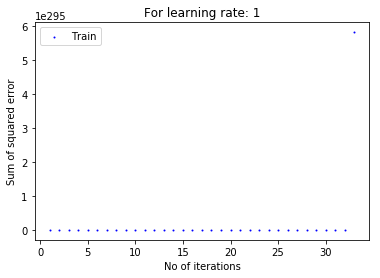

c:\users\daman\python\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


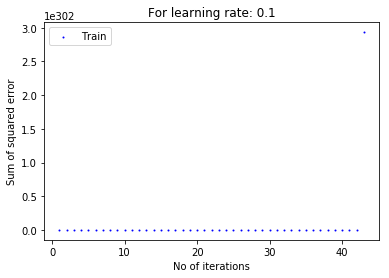

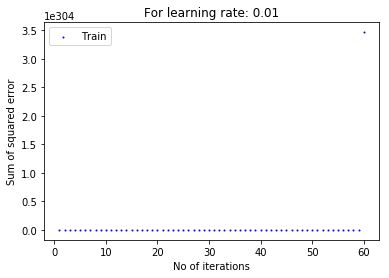

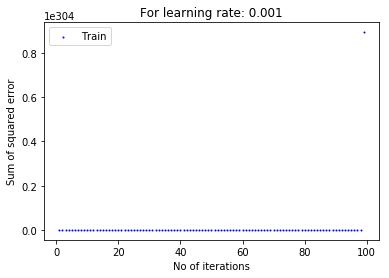

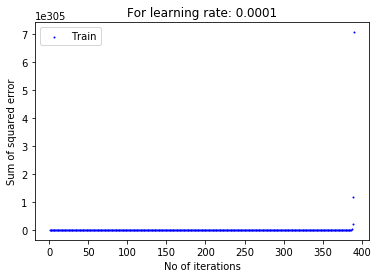

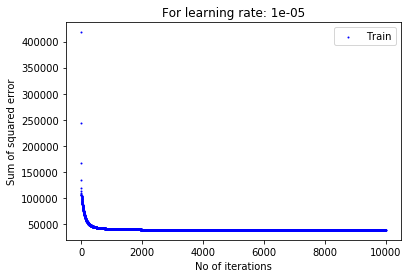

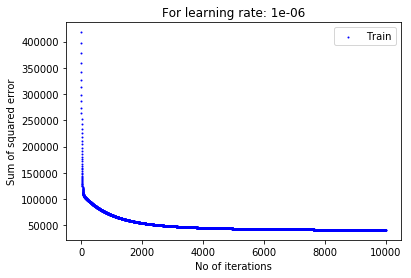

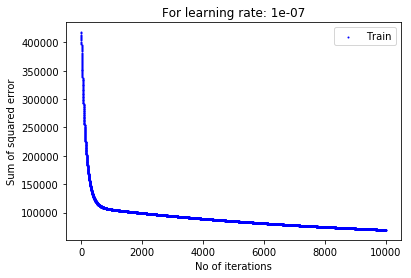

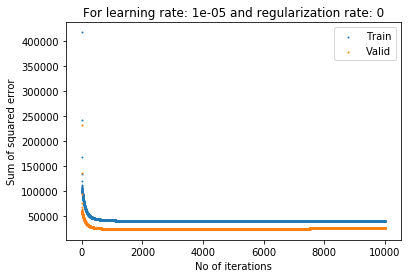

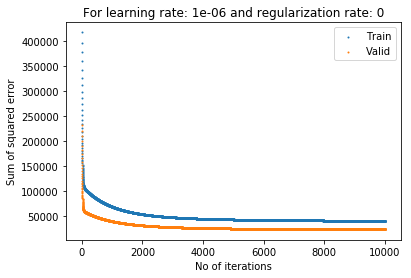

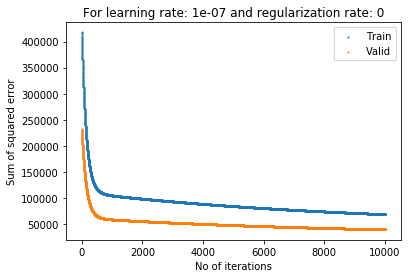

In [46]:
learning_rate = [ 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7 ]
regularize_lambda = 0
epsilon = 0.5          # threshold for norm of the gradient
max_iter = 10000
m = TrainModel()
for lambda_val in learning_rate:
    W, cost = m.train_gradient_descent(train_data, regularize_lambda, lambda_val, epsilon, max_iter)
    m.plot_results(lambda_val, cost)
    
learn_rate = [1e-5, 1e-6, 1e-7]
feature_weights = []
for lambda_val in learn_rate:
    W, cost, cost_val = m.train_gradient_descent_with_val(train_data, val_data, regularize_lambda, lambda_val, epsilon, max_iter)
    m.plot_val_results(lambda_val, regularize_lambda, cost, cost_val)
    feature_weights.append(W)

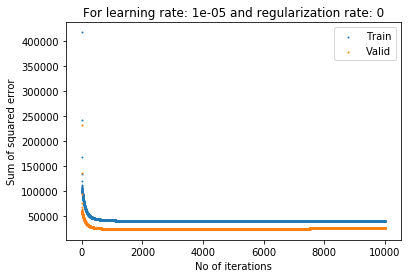

[[-2.35643404]
 [-3.2821391 ]
 [ 3.08932856]
 [ 6.52440689]
 [ 0.38224285]
 [ 0.16543876]
 [ 4.7705391 ]
 [ 2.37728525]
 [ 1.22164012]
 [ 9.18268136]
 [ 6.96241984]
 [ 1.10345924]
 [-2.91148908]
 [ 0.30096648]
 [-0.98266121]
 [ 3.77648133]
 [-2.70022146]
 [ 1.55923455]
 [-0.60760039]
 [-0.17287585]
 [ 0.18958805]
 [ 0.38246277]]


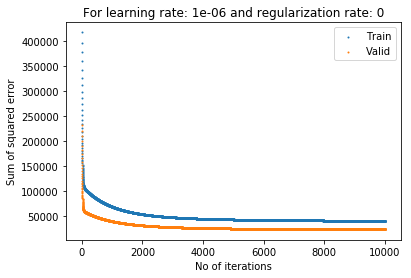

[[-1.68781444]
 [ 0.1426307 ]
 [ 3.04411873]
 [ 4.78769503]
 [ 0.1644504 ]
 [ 1.28937243]
 [ 2.38061913]
 [ 3.20105024]
 [ 0.90085967]
 [ 6.65248862]
 [ 4.76487092]
 [ 1.88422888]
 [-2.86281049]
 [ 0.41940995]
 [-0.91660649]
 [ 3.70382485]
 [-1.6408671 ]
 [ 4.08216037]
 [ 0.0905509 ]
 [-0.27307456]
 [-0.1861005 ]
 [ 0.16381045]]


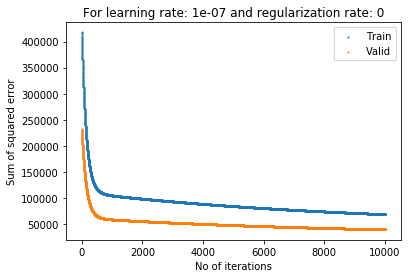

[[ 0.6486106 ]
 [ 0.25600724]
 [ 1.4018112 ]
 [ 1.76268831]
 [ 0.06482067]
 [ 1.16257448]
 [ 0.54014808]
 [ 1.90077795]
 [ 0.72255666]
 [ 2.41788083]
 [ 1.56821519]
 [ 1.27450208]
 [ 0.06400557]
 [ 0.56017079]
 [-0.09244783]
 [ 2.01890488]
 [ 0.08910614]
 [ 1.9240463 ]
 [ 0.0757985 ]
 [-0.09369776]
 [ 0.18934855]
 [ 0.20084735]]


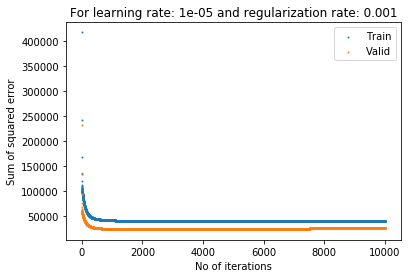

[[-2.35639452]
 [-3.28221281]
 [ 3.0893566 ]
 [ 6.52434472]
 [ 0.38224456]
 [ 0.16546858]
 [ 4.77046282]
 [ 2.37729652]
 [ 1.22163489]
 [ 9.1825989 ]
 [ 6.96234672]
 [ 1.10346988]
 [-2.91148853]
 [ 0.30096798]
 [-0.98267129]
 [ 3.77647544]
 [-2.70025114]
 [ 1.55934152]
 [-0.60758981]
 [-0.17287643]
 [ 0.18958617]
 [ 0.38246133]]


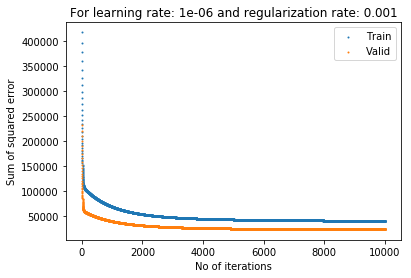

[[-1.6878008 ]
 [ 0.14263247]
 [ 3.0441161 ]
 [ 4.78768403]
 [ 0.16445017]
 [ 1.2893774 ]
 [ 2.38061018]
 [ 3.20104773]
 [ 0.90085897]
 [ 6.65247469]
 [ 4.76485875]
 [ 1.88422837]
 [-2.86280952]
 [ 0.41940993]
 [-0.91660924]
 [ 3.70382085]
 [-1.64086879]
 [ 4.08215569]
 [ 0.09055133]
 [-0.27307426]
 [-0.18609936]
 [ 0.1638108 ]]


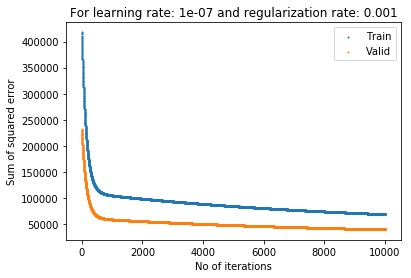

[[ 0.6486117 ]
 [ 0.25600715]
 [ 1.40181067]
 [ 1.76268759]
 [ 0.06482064]
 [ 1.1625741 ]
 [ 0.54014783]
 [ 1.90077713]
 [ 0.72255653]
 [ 2.4178799 ]
 [ 1.56821456]
 [ 1.27450156]
 [ 0.06400586]
 [ 0.56017055]
 [-0.09244767]
 [ 2.01890422]
 [ 0.08910621]
 [ 1.92404555]
 [ 0.07579847]
 [-0.09369754]
 [ 0.18934866]
 [ 0.20084737]]


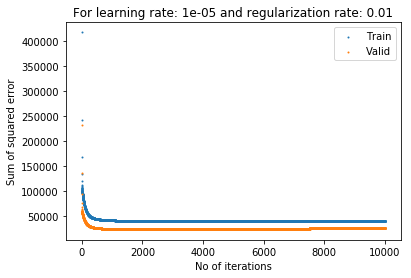

[[-2.35603891]
 [-3.28287633]
 [ 3.08960893]
 [ 6.52378535]
 [ 0.38225994]
 [ 0.16573696]
 [ 4.76977642]
 [ 2.37739786]
 [ 1.22158784]
 [ 9.18185687]
 [ 6.9616888 ]
 [ 1.10356569]
 [-2.91148365]
 [ 0.30098146]
 [-0.98276203]
 [ 3.77642242]
 [-2.70051826]
 [ 1.56030397]
 [-0.60749455]
 [-0.17288166]
 [ 0.18956926]
 [ 0.38244832]]


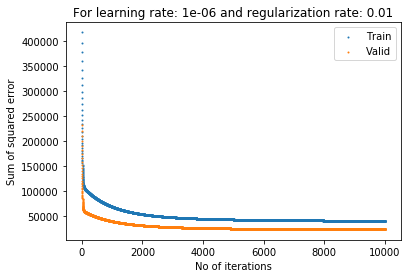

[[-1.68767801]
 [ 0.14264837]
 [ 3.04409243]
 [ 4.78758501]
 [ 0.16444807]
 [ 1.28942207]
 [ 2.38052956]
 [ 3.20102507]
 [ 0.90085271]
 [ 6.65234928]
 [ 4.7647492 ]
 [ 1.88422376]
 [-2.86280081]
 [ 0.41940975]
 [-0.91663398]
 [ 3.70378489]
 [-1.64088399]
 [ 4.08211363]
 [ 0.09055521]
 [-0.27307152]
 [-0.18608908]
 [ 0.16381402]]


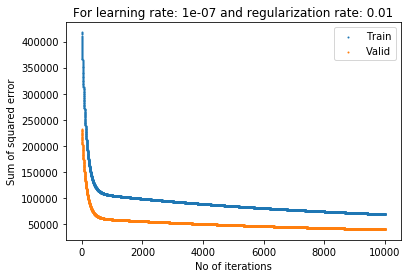

[[ 0.64862158]
 [ 0.25600639]
 [ 1.40180594]
 [ 1.76268111]
 [ 0.06482041]
 [ 1.16257063]
 [ 0.54014559]
 [ 1.90076977]
 [ 0.72255534]
 [ 2.41787155]
 [ 1.56820882]
 [ 1.27449681]
 [ 0.06400845]
 [ 0.56016839]
 [-0.09244623]
 [ 2.01889833]
 [ 0.08910684]
 [ 1.92403879]
 [ 0.07579822]
 [-0.09369559]
 [ 0.18934958]
 [ 0.20084756]]


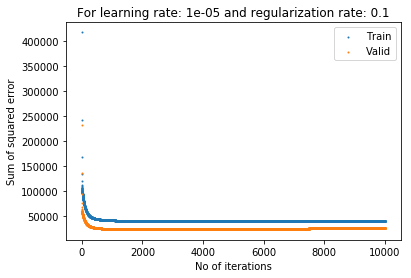

[[-2.35248202]
 [-3.28952501]
 [ 3.09212343]
 [ 6.51820521]
 [ 0.38241092]
 [ 0.16841719]
 [ 4.76292342]
 [ 2.37840939]
 [ 1.2211173 ]
 [ 9.17444847]
 [ 6.95512471]
 [ 1.10452383]
 [-2.91143424]
 [ 0.30111594]
 [-0.98367058]
 [ 3.77589264]
 [-2.70319173]
 [ 1.56990465]
 [-0.60653723]
 [-0.17293392]
 [ 0.18940015]
 [ 0.38231824]]


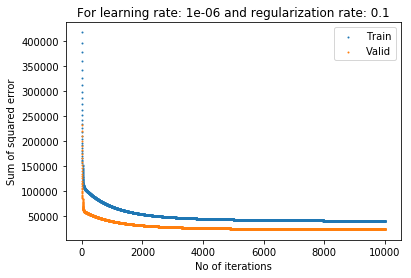

[[-1.68645025]
 [ 0.14280726]
 [ 3.04385573]
 [ 4.78659506]
 [ 0.16442704]
 [ 1.28986863]
 [ 2.37972366]
 [ 3.20079854]
 [ 0.90079006]
 [ 6.65109547]
 [ 4.76365393]
 [ 1.88417763]
 [-2.86271378]
 [ 0.41940789]
 [-0.91688146]
 [ 3.70342532]
 [-1.641036  ]
 [ 4.08169303]
 [ 0.09059394]
 [-0.27304412]
 [-0.1859863 ]
 [ 0.16384622]]


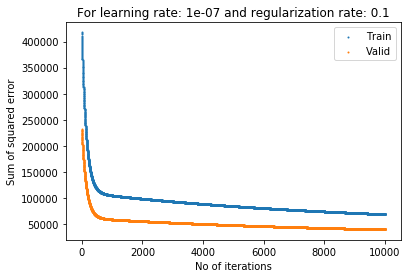

[[ 0.64872039]
 [ 0.25599872]
 [ 1.40175858]
 [ 1.7626164 ]
 [ 0.06481805]
 [ 1.16253592]
 [ 0.54012318]
 [ 1.9006962 ]
 [ 0.72254349]
 [ 2.41778803]
 [ 1.56815147]
 [ 1.27444932]
 [ 0.06403434]
 [ 0.56014682]
 [-0.09243178]
 [ 2.01883942]
 [ 0.08911317]
 [ 1.92397114]
 [ 0.07579566]
 [-0.09367611]
 [ 0.18935885]
 [ 0.20084941]]


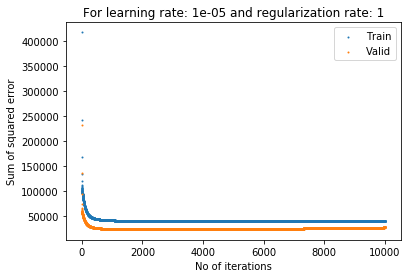

[[-2.31683744]
 [-3.35737826]
 [ 3.11641518]
 [ 6.46373013]
 [ 0.38364542]
 [ 0.19487124]
 [ 4.69547945]
 [ 2.38833222]
 [ 1.21640741]
 [ 9.10153426]
 [ 6.89096985]
 [ 1.11410912]
 [-2.91088331]
 [ 0.30242833]
 [-0.99287083]
 [ 3.77063331]
 [-2.73015706]
 [ 1.6635725 ]
 [-0.59647279]
 [-0.17345499]
 [ 0.18770939]
 [ 0.38102016]]


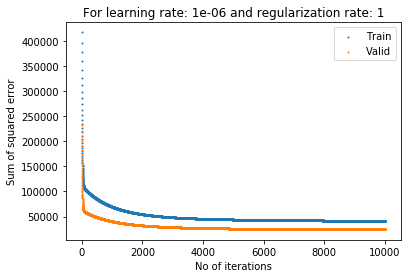

[[-1.67418325]
 [ 0.14438878]
 [ 3.04148771]
 [ 4.77671961]
 [ 0.16421693]
 [ 1.2943167 ]
 [ 2.37168862]
 [ 3.19853237]
 [ 0.90016014]
 [ 6.63858396]
 [ 4.75272951]
 [ 1.88371219]
 [-2.86184846]
 [ 0.4193878 ]
 [-0.91935787]
 [ 3.6998333 ]
 [-1.64256376]
 [ 4.07748935]
 [ 0.09097914]
 [-0.27277024]
 [-0.18495794]
 [ 0.16416838]]


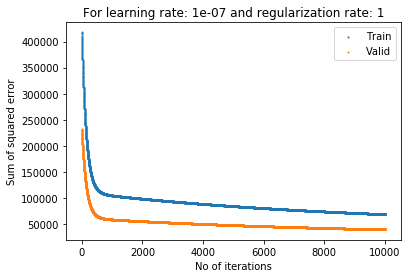

[[ 0.64970836]
 [ 0.25592211]
 [ 1.40128513]
 [ 1.76196945]
 [ 0.06479451]
 [ 1.16218894]
 [ 0.53989917]
 [ 1.89996069]
 [ 0.72242492]
 [ 2.41695304]
 [ 1.56757811]
 [ 1.27397462]
 [ 0.06429315]
 [ 0.55993112]
 [-0.09228735]
 [ 2.0182504 ]
 [ 0.08917647]
 [ 1.92329491]
 [ 0.07577016]
 [-0.09348129]
 [ 0.18945143]
 [ 0.20086789]]


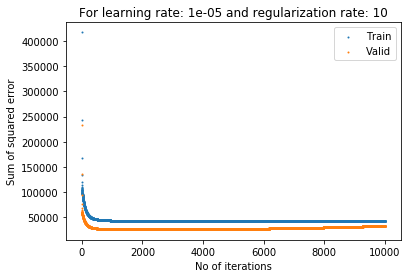

[[-1.95167223]
 [-4.18705286]
 [ 3.2930155 ]
 [ 6.02864879]
 [ 0.37465036]
 [ 0.42905819]
 [ 4.1147299 ]
 [ 2.47001718]
 [ 1.16968228]
 [ 8.4724051 ]
 [ 6.37266756]
 [ 1.20911358]
 [-2.89989664]
 [ 0.31297758]
 [-1.09650151]
 [ 3.72164636]
 [-3.02982947]
 [ 2.40808172]
 [-0.42745216]
 [-0.1785197 ]
 [ 0.17103183]
 [ 0.36842792]]


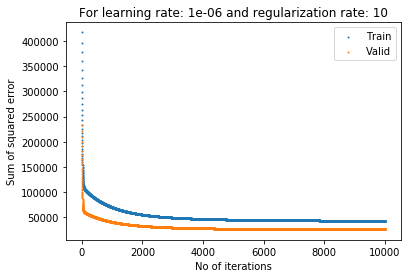

[[-1.55256707]
 [ 0.15948334]
 [ 3.01772632]
 [ 4.68031504]
 [ 0.16212872]
 [ 1.33709207]
 [ 2.29367467]
 [ 3.1757928 ]
 [ 0.89353311]
 [ 6.51607387]
 [ 4.64624874]
 [ 1.87865715]
 [-2.85369828]
 [ 0.41903675]
 [-0.94429332]
 [ 3.66428193]
 [-1.65860573]
 [ 4.03568892]
 [ 0.09462585]
 [-0.27004178]
 [-0.1746149 ]
 [ 0.16741618]]


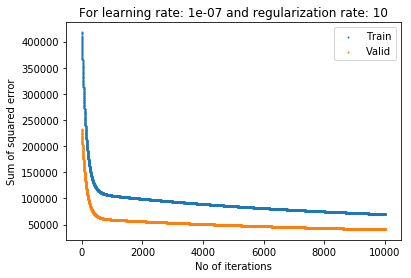

[[ 0.65957308]
 [ 0.25515772]
 [ 1.39656346]
 [ 1.75551875]
 [ 0.06455973]
 [ 1.15872789]
 [ 0.53766614]
 [ 1.89262796]
 [ 0.72123831]
 [ 2.40862604]
 [ 1.56186121]
 [ 1.26924148]
 [ 0.06686739]
 [ 0.55778047]
 [-0.09084683]
 [ 2.01237332]
 [ 0.0898052 ]
 [ 1.91655145]
 [ 0.07551582]
 [-0.09153813]
 [ 0.19037022]
 [ 0.20104972]]


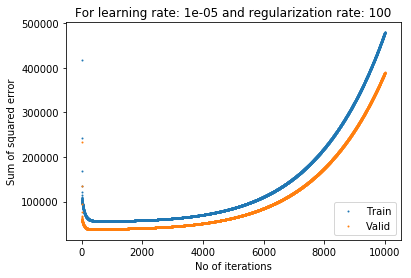

[[ 10.4246062 ]
 [  0.28692143]
 [  2.73284826]
 [  5.61158983]
 [  1.43591646]
 [  0.06448663]
 [  1.62820672]
 [  2.246504  ]
 [  0.96939251]
 [  5.14244749]
 [  6.35234029]
 [ -1.52675811]
 [  1.88869989]
 [  0.8833394 ]
 [-11.29977866]
 [  4.34559341]
 [-47.70588361]
 [  6.84076297]
 [  2.04315113]
 [ -0.2355117 ]
 [  0.09806289]
 [  0.34785078]]


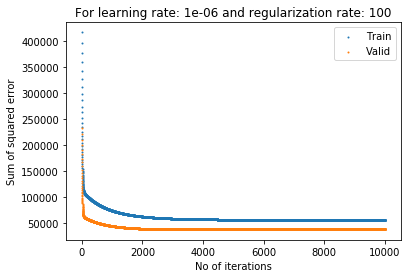

[[-0.42949342]
 [ 0.25556506]
 [ 2.78158461]
 [ 3.90835548]
 [ 0.14292318]
 [ 1.63144265]
 [ 1.70061522]
 [ 2.94645203]
 [ 0.80688451]
 [ 5.51085452]
 [ 3.80630196]
 [ 1.79854431]
 [-2.82049402]
 [ 0.4037468 ]
 [-1.21817091]
 [ 3.34450306]
 [-1.90265892]
 [ 3.64585469]
 [ 0.11583115]
 [-0.24225316]
 [-0.06087947]
 [ 0.20444152]]


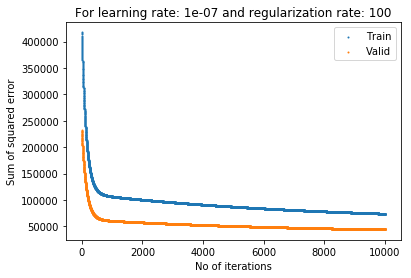

[[ 0.75674752]
 [ 0.24768803]
 [ 1.35060725]
 [ 1.69285221]
 [ 0.0622776 ]
 [ 1.1249707 ]
 [ 0.51602634]
 [ 1.82148264]
 [ 0.70929447]
 [ 2.32759853]
 [ 1.50632058]
 [ 1.22326885]
 [ 0.09126405]
 [ 0.53689456]
 [-0.07682521]
 [ 1.95489479]
 [ 0.09568715]
 [ 1.85096877]
 [ 0.07303911]
 [-0.07262278]
 [ 0.19888056]
 [ 0.20257853]]


In [47]:
learning_rate = [1e-5, 1e-6, 1e-7]
regularize_lambda = [0, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]             
weight_list = {}
m = TrainModel()
for reg_lambda in regularize_lambda:
    for lambda_val in learning_rate:
        Weights, cost, cost_val = m.train_gradient_descent_with_val(train_data, val_data, reg_lambda, lambda_val, epsilon, max_iter)
        m.plot_val_results(lambda_val, reg_lambda, cost, cost_val)
        print(Weights)
        weight_list[lambda_val, reg_lambda] = Weights

c:\users\daman\python\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in square
c:\users\daman\python\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


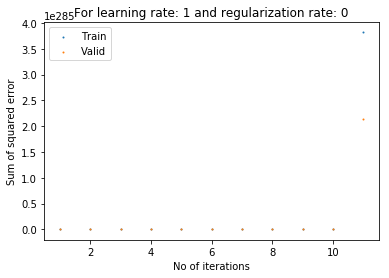

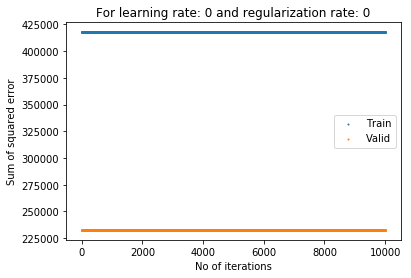

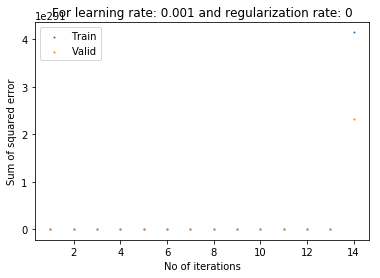

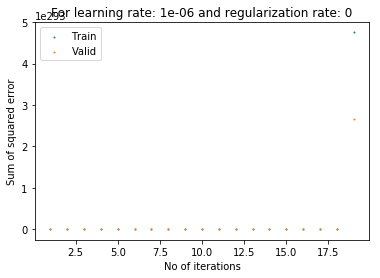

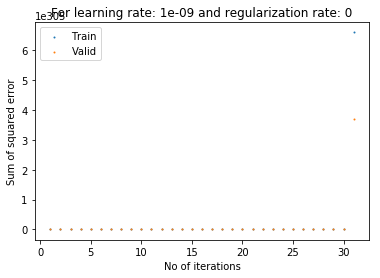

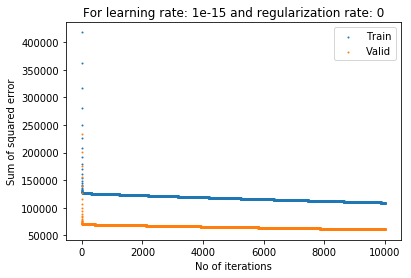

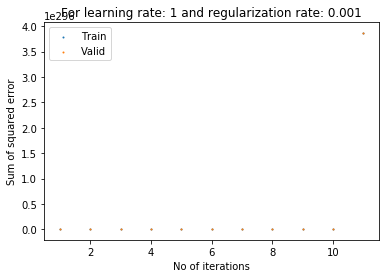

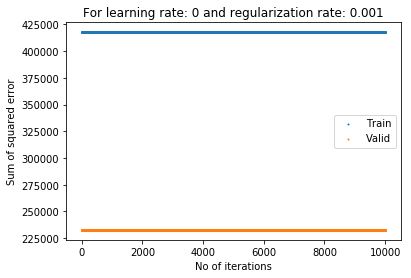

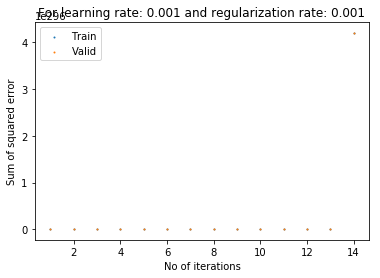

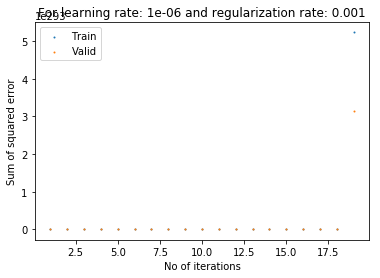

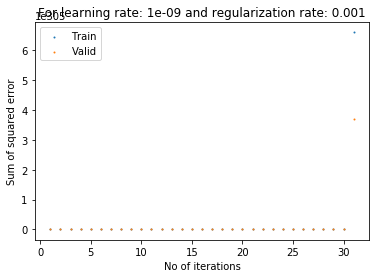

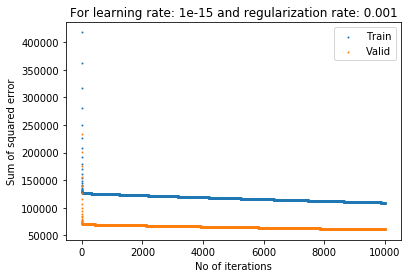

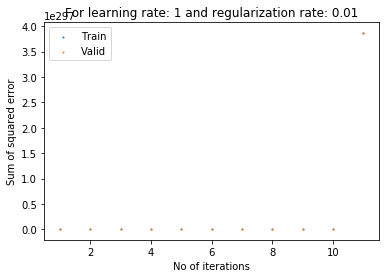

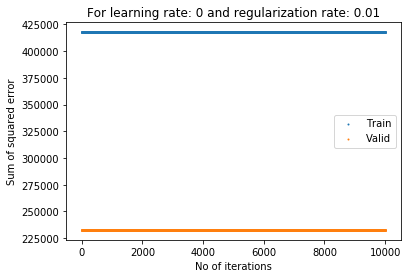

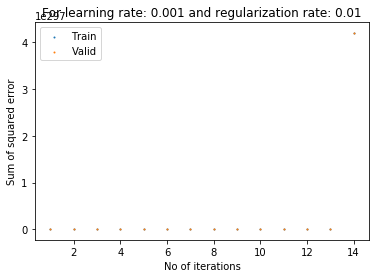

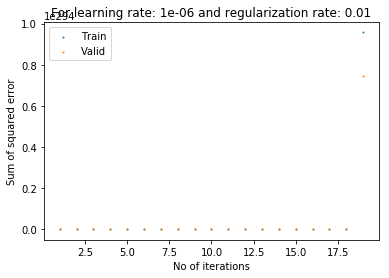

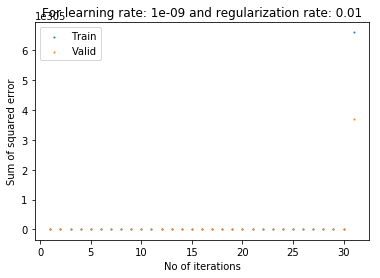

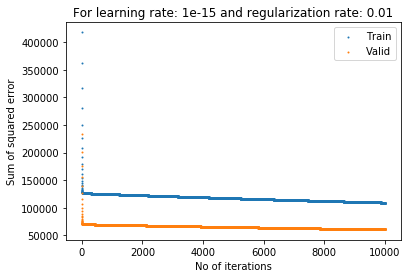

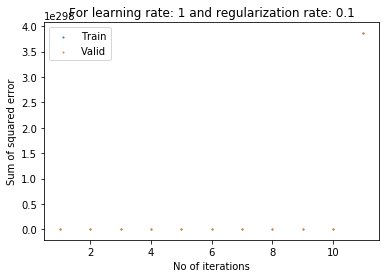

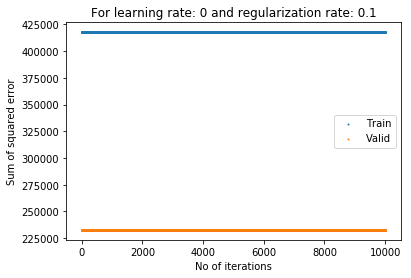

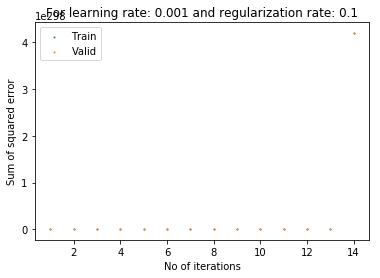

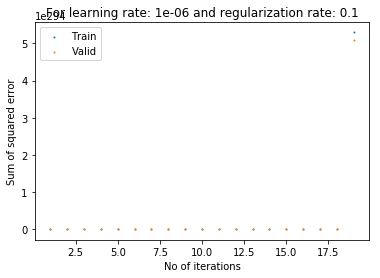

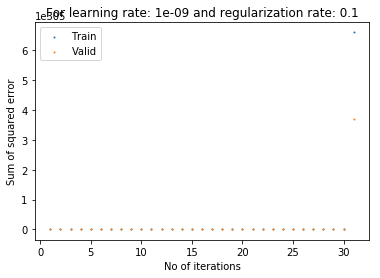

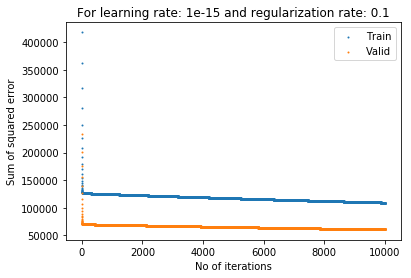

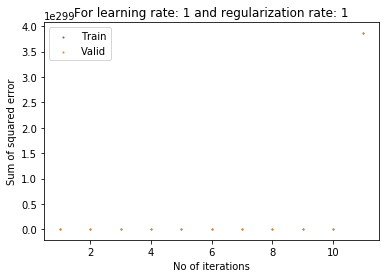

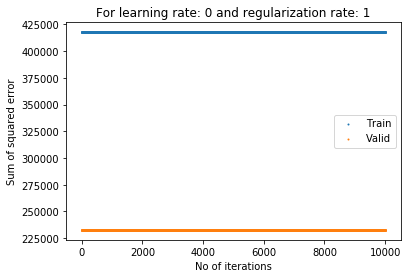

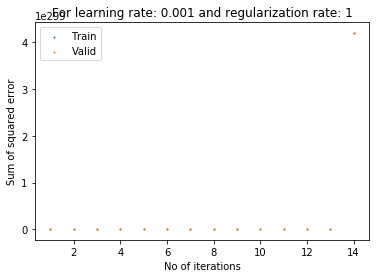

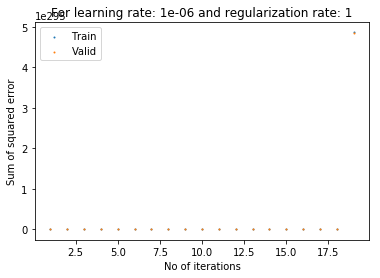

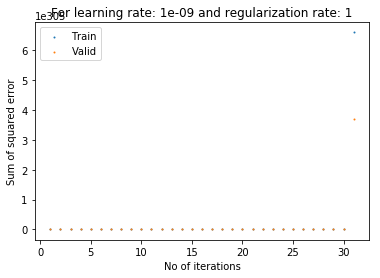

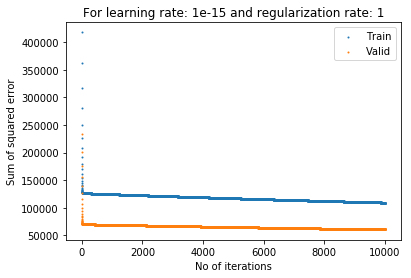

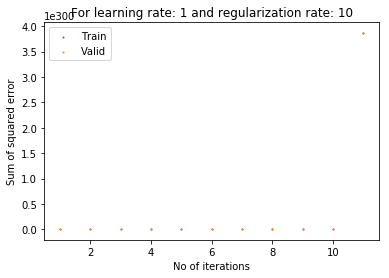

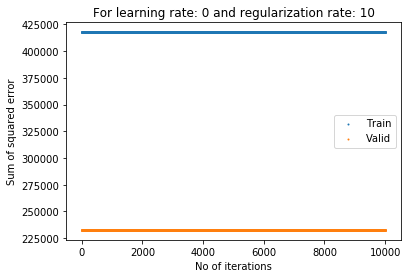

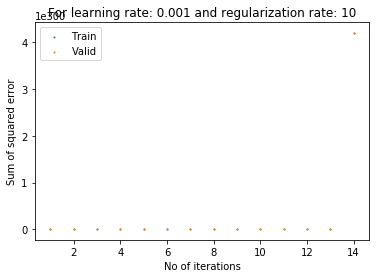

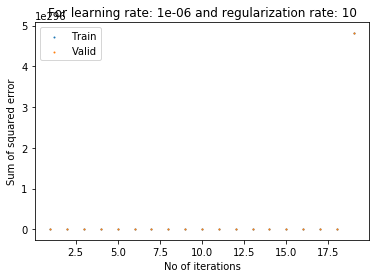

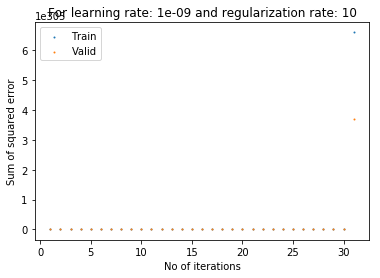

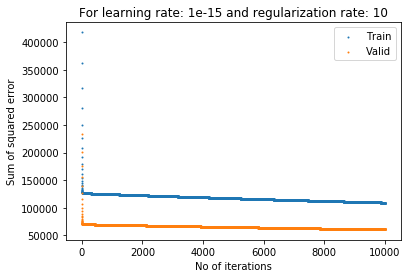

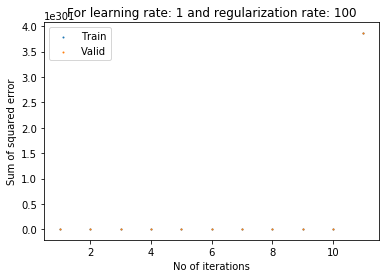

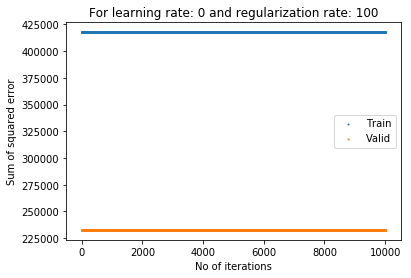

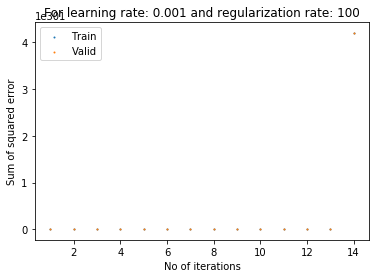

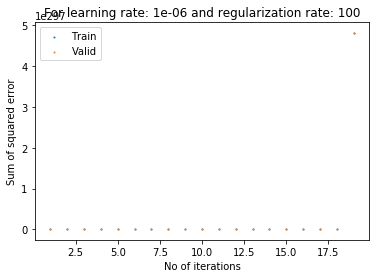

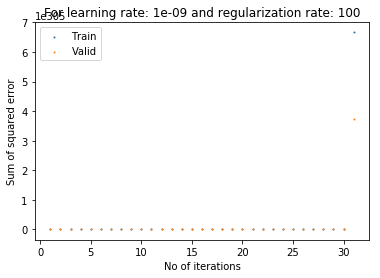

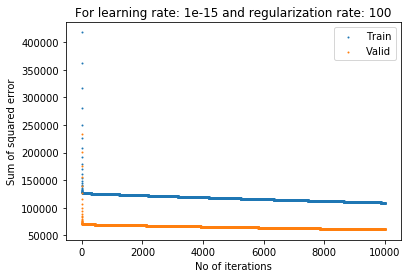

In [48]:
# working with unnormalized data
m = TrainModel()
train_df = unnorm_train_df[['dummy', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
               'sqft_living15', 'sqft_lot15', 'day', 'month', 'year', 'price']]
train_data = train_df.values 
val_df = unnorm_val_df[['dummy', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
               'sqft_living15', 'sqft_lot15', 'day', 'month', 'year', 'price']]
val_data = val_df.values 
learning_rate = [1e0, 0, 1e-3, 1e-6, 1e-9, 1e-15]
regularize_lambda = [0, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]             
max_iterations = int(1e4)
unnorm_weights = {}

for r_lambda in regularize_lambda:
    for lambda_val in learning_rate:
        Weights, cost, cost_val = m.train_gradient_descent_with_val(train_data, val_data, r_lambda, lambda_val, epsilon, max_iterations)
        m.plot_val_results(lambda_val, r_lambda, cost, cost_val)
        unnorm_weights[lambda_val, r_lambda] = Weights

In [49]:
# choose the final weights
Weights = weight_list[1e-05, 0.001]
y_test_pred = predict_output(test_data, Weights)
np.savetxt("output.txt", y_test_pred, delimiter = '\n')